In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def make_ax(): #axisの準備
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)                  
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    return ax

def draw_trajectory(xs, ax): #軌跡の描画
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax): #センサ値の描画
    for s in range(len(xs)):
        if s not in zlist:
            continue
            
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi = obs[1][0], obs[1][1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax):
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1] ,e.x2[1]], color="red", alpha=0.5)
        
def draw_landmarks(ms, ax): 
    ax.scatter([ms[k][0] for k in ms], [ms[k][1] for k in ms], s=100, marker="*", color="blue", zorder=100)
    
def draw(xs, zlist, edges, ms={}):  #ms追加
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_trajectory(xs, ax)
    draw_landmarks(ms, ax)  #追加
    plt.show()

In [3]:
def read_data():
    hat_xs = {} 
    zlist = {} 
    delta = 0.0
    us = {}

    with open("log2_for_book.txt") as f: #log2.txtに変えておく
        for line in f.readlines():
            tmp = line.rstrip().split()

            step = int(tmp[1])
            if tmp[0] == "x": 
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z": 
                if step not in zlist: 
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4])]).T)) #変更。ψを読み込まないように
            elif tmp[0] == "delta": 
                delta = float(tmp[1])
            elif tmp[0] == "u":
                us[step] = np.array([float(tmp[2]), float(tmp[3])]).T 
                
        return hat_xs, zlist, us, delta #us, deltaも返す

In [4]:
class ObsEdge: 
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05]):  #ψの標準偏差を削除
        assert z1[0] == z2[0] 

        self.t1, self.t2 = t1, t2  
        self.x1, self.x2 = xs[t1], xs[t2]
        self.z1, self.z2 = z1[1], z2[1]
        
        s1 = math.sin(self.x1[2] + self.z1[1]) 
        c1 = math.cos(self.x1[2] + self.z1[1])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])

        ##誤差の計算##
        hat_e = self.x2[0:2] - self.x1[0:2] + np.array([       #self.x2とself.x1は上の2行だけを使う
            self.z2[0]*c2 - self.z1[0]*c1, 
            self.z2[0]*s2 - self.z1[0]*s1
        ])                                                                   #ψに関する行列の行と、正規化していた行を削除。
            
        ##精度行列の作成## 
        Q1 = np.diag([(self.z1[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2]) #ψの分散を削除
        R1 = - np.array([[c1, -self.z1[0]*s1],
                                     [s1,  self.z1[0]*c1]])    #3行目、3列目を削除
        
        Q2 = np.diag([(self.z2[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2]) #ψの分散を削除
        R2 = np.array([[c2, -self.z2[0]*s2],
                                  [s2,  self.z2[0]*c2]])    #3行目、3列目を削除
        
        Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        Omega = np.linalg.inv(Sigma)                                                  #2x2行列になる
        
        ##大きな精度行列と係数ベクトルの各部分を計算##
        B1 = - np.array([[1, 0, -self.z1[0]*s1],
                                    [0, 1, self.z1[0]*c1]])                                  #3行目を削除
        B2 = np.array([[1, 0,  -self.z2[0]*s2],
                                   [0, 1,   self.z2[0]*c2]])                                  #3行目を削除
        
        self.omega_upperleft = B1.T.dot(Omega).dot(B1)         #ここは計算すると3x3行列のままになる
        self.omega_upperright = B1.T.dot(Omega).dot(B2)
        self.omega_bottomleft = B2.T.dot(Omega).dot(B1)
        self.omega_bottomright = B2.T.dot(Omega).dot(B2)
        
        self.xi_upper = - B1.T.dot(Omega).dot(hat_e)         #ここも計算すると3次元縦ベクトルのままになる
        self.xi_bottom = - B2.T.dot(Omega).dot(hat_e)

In [5]:
class MotionEdge:
    def __init__(self, t1, t2, xs, us, delta, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        self.t1, self.t2 = t1, t2                   #時刻の記録
        self.hat_x1, self.hat_x2 = xs[t1], xs[t2]    #各時刻の姿勢

        nu, omega = us[t2]
        if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける

        M = matM(nu, omega, delta, motion_noise_stds)
        A = matA(nu, omega, delta, self.hat_x1[2])
        F = matF(nu, omega, delta, self.hat_x1[2])
        
        self.Omega = np.linalg.inv(A.dot(M).dot(A.T) + np.eye(3)*0.0001) #標準偏差0.01の雑音を足す
        
        self.omega_upperleft = F.T.dot(self.Omega).dot(F)
        self.omega_upperright = -F.T.dot(self.Omega)
        self.omega_bottomleft = - self.Omega.dot(F)
        self.omega_bottomright = self.Omega
        
        x2 = IdealRobot.state_transition(nu, omega, delta, self.hat_x1)
        self.xi_upper = F.T.dot(self.Omega).dot(self.hat_x2 - x2)
        self.xi_bottom = -self.Omega.dot(self.hat_x2 - x2)

In [6]:
import itertools 
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {}

    for step in zlist: 
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist: 
                landmark_keys_zlist[landmark_id] = []

            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2))
        edges += [ObsEdge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
        
    return edges, landmark_keys_zlist #ランドマークをキーにしたリストlandmark_keys_zlistも返す

In [7]:
def add_edge(edge, Omega, xi): 
    f1, f2 = edge.t1*3, edge.t2*3
    t1 ,t2 = f1 + 3, f2 + 3
    Omega[f1:t1, f1:t1] += edge.omega_upperleft
    Omega[f1:t1, f2:t2] += edge.omega_upperright
    Omega[f2:t2, f1:t1] += edge.omega_bottomleft
    Omega[f2:t2, f2:t2] += edge.omega_bottomright
    xi[f1:t1] += edge.xi_upper
    xi[f2:t2] += edge.xi_bottom

1回目の繰り返し: 6.136262177884366
2回目の繰り返し: 1.3559457361597533
3回目の繰り返し: 0.7267587784735493
4回目の繰り返し: 0.4023156102444334
5回目の繰り返し: 0.2233059345550695
6回目の繰り返し: 0.12405482944406157
7回目の繰り返し: 0.0690533288123464
8回目の繰り返し: 0.038565223002431204
9回目の繰り返し: 0.021664717711960723
10回目の繰り返し: 0.012296689642532114
11回目の繰り返し: 0.007105172508603679


<IPython.core.display.Javascript object>


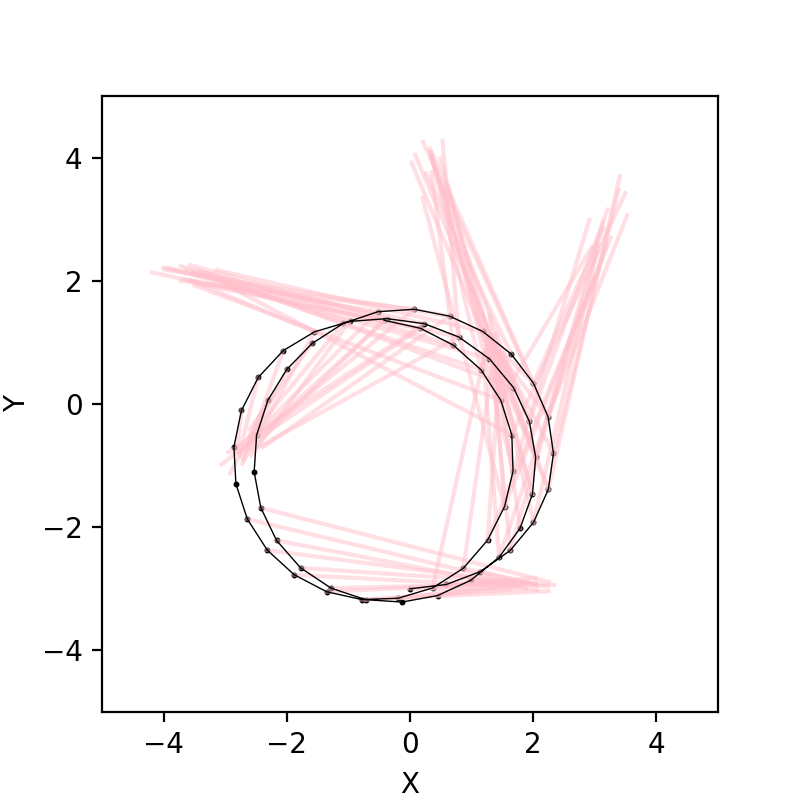

In [8]:
hat_xs, zlist, us, delta = read_data()  
dim = len(hat_xs)*3

for n in range(1, 10000): 
    ##エッジ、大きな精度行列、係数ベクトルの作成##
    edges, _ = make_edges(hat_xs, zlist)

    for i in range(len(hat_xs)-1):  ###graphbasedslam2d2
        for j in range(100):
            edges.append(MotionEdge(i, i+1, hat_xs, us, delta))  #100回同じエッジを足して移動エッジを増強
        
    Omega = np.zeros((dim, dim))
    xi = np.zeros(dim)
    Omega[0:3, 0:3] += np.eye(3)*1000000

    ##軌跡を動かす量（差分）の計算##
    for e in edges:
        add_edge(e, Omega, xi) 

    delta_xs = np.linalg.inv(Omega).dot(xi) 
    
    ##推定値の更新##
    for i in range(len(hat_xs)):
        hat_xs[i] += delta_xs[i*3:(i+1)*3] 
        
    ##終了判定##
    diff = np.linalg.norm(delta_xs) 
    print("{}回目の繰り返し: {}".format(n, diff))
    if diff < 0.01:
        draw(hat_xs, zlist, edges)
        break

In [9]:
_, zlist_landmark = make_edges(hat_xs, zlist) 
zlist_landmark

{1: [(0, (1, array([ 1.88300129e+00, -9.10365521e-04]))),
  (1, (1, array([ 1.24050936, -0.19381247]))),
  (2, (1, array([ 0.90805059, -0.71609643]))),
  (20, (1, array([4.83107531, 1.00937034]))),
  (21, (1, array([4.30010629, 0.79353638]))),
  (22, (1, array([4.12765897, 0.65313003]))),
  (23, (1, array([3.03472701, 0.47739555]))),
  (24, (1, array([2.35685846, 0.25789427]))),
  (26, (1, array([ 1.60907086, -0.17349848]))),
  (27, (1, array([ 1.24928103, -0.637254  ]))),
  (45, (1, array([4.41015024, 0.89420669]))),
  (46, (1, array([3.89270852, 0.7411044 ]))),
  (47, (1, array([3.67420675, 0.55651282]))),
  (48, (1, array([3.00353853, 0.40351862]))),
  (49, (1, array([3.03422889, 0.12975794]))),
  (50, (1, array([ 2.11565818, -0.03240272]))),
  (51, (1, array([ 1.67265141, -0.32031852]))),
  (52, (1, array([ 1.2284749 , -0.95087292])))],
 2: [(3, (2, array([5.03780741, 0.54540483]))),
  (4, (2, array([4.62828723, 0.32673702]))),
  (5, (2, array([5.21252669, 0.06402379]))),
  (6, (2,

In [10]:
class MapEdge:
    def __init__(self, t, z, head_t, head_z, xs, sensor_noise_rate=[0.14, 0.05]):  #センサの雑音モデルを削除
        self.x = xs[t]
        self.z = z
        
        self.m = self.x[0:2] + np.array([z[0]*math.cos(self.x[2] + z[1]), z[0]*math.sin(self.x[2] + z[1])]).T  #3行目削除
            
        ##精度行列の計算## 
        Q1 = np.diag([(self.z[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2]) #ψの分散を削除
        
        s1 = math.sin(self.x[2] + self.z[1]) 
        c1 = math.cos(self.x[2] + self.z[1])
        R = np.array([[-c1, self.z[0]*s1],
                                [-s1,-self.z[0]*c1]]) #3行目、3列目を削除
        
        self.Omega = R.dot(Q1).dot(R.T) #2x2行列になる
        self.xi = self.Omega.dot(self.m)   #2次元ベクトルになる

<IPython.core.display.Javascript object>


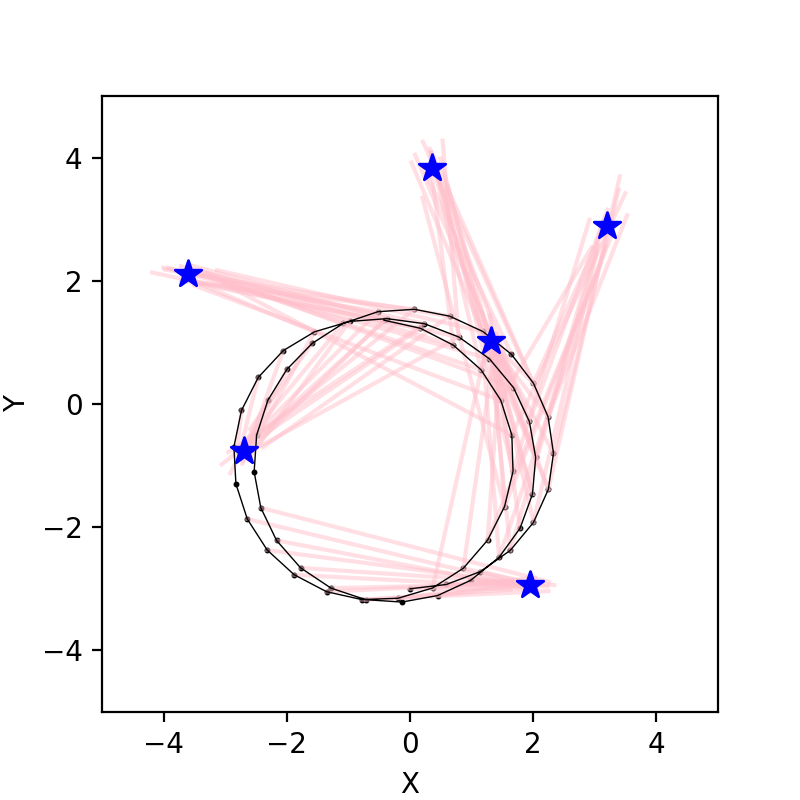

In [11]:
ms = {}
for landmark_id in zlist_landmark:
    edges = []
    head_z = zlist_landmark[landmark_id][0]
    for z in zlist_landmark[landmark_id]:
        edges.append(MapEdge(z[0], z[1][1], head_z[0], head_z[1][1], hat_xs))
        
    Omega = np.zeros((2,2)) #2x2に
    xi = np.zeros(2)                 #2次元に
    for e in edges:
        Omega += e.Omega
        xi += e.xi
        
    ms[landmark_id] = np.mean([e.m for e in edges], axis=0)
    
draw(hat_xs, zlist, edges, ms)

In [12]:
actual_pos = [(-4,2), (2,-3), (3,3), (0,4), (1,1), (-3,-1)]
ms

{1: array([ 1.94056849, -2.93168492]),
 2: array([3.19212047, 2.89582324]),
 4: array([1.32091105, 1.02977656]),
 3: array([0.36045777, 3.82789055]),
 0: array([-3.60705485,  2.11027068]),
 5: array([-2.69038469, -0.76900541])}

In [13]:
from decimal import Decimal, ROUND_HALF_UP
def distance(landmark_id, ref_id1, ref_id2, ms):
    m, ref_m1, ref_m2 = ms[landmark_id], ms[ref_id1], ms[ref_id2]
    d = math.sqrt( (m[0]-ref_m1[0])**2 + (m[1]-ref_m1[1])**2 )
    ang = math.atan2(m[1] - ref_m1[1], m[0] - ref_m1[0]) - math.atan2(ref_m2[1] - ref_m1[1], ref_m2[0] - ref_m1[0])
    return Decimal(d).quantize(Decimal("0.01"), rounding=ROUND_HALF_UP), Decimal(ang/math.pi*180).quantize(Decimal("0.1"), rounding=ROUND_HALF_UP)

In [14]:
for i in range(1,6):
    d, ang = distance(i, 0, 1, ms)
    true_d, true_ang = distance(i, 0, 1, actual_pos)
    print(i, true_d, true_ang, d, ang, d - true_d, ang - true_ang)

1 7.81 0.0 7.50 0.0 -0.31 0.0
2 7.07 47.9 6.84 48.9 -0.23 1.0
3 4.47 66.4 4.32 65.7 -0.15 -0.7
4 5.10 28.5 5.05 29.9 -0.05 1.4
5 3.16 -31.8 3.02 -30.1 -0.14 1.7
